# Access InfluxDB from Python
Inspired by https://www.influxdata.com/blog/getting-started-python-influxdb/

In [3]:
from influxdb import InfluxDBClient
from ruamel.yaml import YAML
import pandas as pd
import datetime as dt

## Make the client and connect to a database

In [4]:
with open("secrets.yaml", "r") as file:
    secrets = YAML().load(file)

client = InfluxDBClient(host=secrets["influx"]["host"], 
                        port=secrets["influx"]["port"], 
                        username=secrets["influx"]["username"], 
                        password=secrets["influx"]["password"])

client.get_list_database()

[{'name': '_internal'},
 {'name': 'influx_db_1'},
 {'name': 'influx_db_2'},
 {'name': 'influx_db_3'},
 {'name': 'influx_db_4'}]

In [5]:
client.switch_database('influx_db_4')

## show series

In [6]:
points = [p["key"].replace("\\", "") for p in client.query("show series").get_points()]
for i, point in enumerate(points):
    print(i, point)

0 %,domain=sensor,entity_id=benni_battery
1 %,domain=sensor,entity_id=benni_moisture
2 %,domain=sensor,entity_id=cooper_se_charging_target
3 %,domain=sensor,entity_id=cooper_se_remaining_battery_percent
4 %,domain=sensor,entity_id=disk_use_percent
5 %,domain=sensor,entity_id=memory_use_percent
6 %,domain=sensor,entity_id=moto_g54_5g_battery_level
7 %,domain=sensor,entity_id=my_sensor
8 %,domain=sensor,entity_id=mz_shutter_ff_bath_illuminance
9 %,domain=sensor,entity_id=mz_shutter_ff_lara_l_illuminance
10 %,domain=sensor,entity_id=mz_shutter_ff_lara_m_illuminance
11 %,domain=sensor,entity_id=mz_shutter_ff_lara_r_illuminance
12 %,domain=sensor,entity_id=mz_shutter_ff_sleep_l_illuminance
13 %,domain=sensor,entity_id=mz_shutter_ff_sleep_r_illuminance
14 %,domain=sensor,entity_id=mz_shutter_gf_kitchen_illuminance
15 %,domain=sensor,entity_id=mz_shutter_gf_toilet_illuminance
16 %,domain=sensor,entity_id=mz_shutter_sf_studio_l_illuminance
17 %,domain=sensor,entity_id=openweathermap_cloud_cove

## Query simple 

In [7]:
qstr = f'SELECT * FROM "m³/h" WHERE TIME >= now() -1d'
print(f"{qstr=}")
df = pd.DataFrame.from_records(client.query(qstr).get_points())
df.tail(3)

qstr='SELECT * FROM "m³/h" WHERE TIME >= now() -1d'


,time,domain,entity_id,mean_value
26,2024-06-01T23:00:00Z,sensor,watermeter_rate_per_time_unit,0.0024
27,2024-06-02T04:00:00Z,sensor,gasmeter2_rate_per_time_unit,0.0300
28,2024-06-02T05:00:00Z,sensor,gasmeter2_rate_per_time_unit,0.3830


In [8]:
df.time = pd.to_datetime(df.time)
df = df.set_index("time")
df.head()

,domain,entity_id,mean_value
time,,,
2024-06-01 07:00:00+00:00,sensor,gasmeter2_rate_per_time_unit,0.10500
2024-06-01 07:00:00+00:00,sensor,watermeter_rate_per_time_unit,0.02676
2024-06-01 08:00:00+00:00,sensor,gasmeter2_rate_per_time_unit,0.13700
2024-06-01 08:00:00+00:00,sensor,watermeter_rate_per_time_unit,0.01190
2024-06-01 09:00:00+00:00,sensor,gasmeter2_rate_per_time_unit,0.10400


In [9]:
df.entity_id.value_counts()

entity_id
watermeter_rate_per_time_unit    15
gasmeter2_rate_per_time_unit     14
Name: count, dtype: int64

## Query with datetime filter

In [10]:
unit = "m³"
entity_id = "watermeter_value"
selection = "mean_value"
qstr = f'SELECT {selection} FROM "{unit}" WHERE {entity_id=}'
qstr

'SELECT mean_value FROM "m³" WHERE entity_id=\'watermeter_value\''

Simple query string w/o datetime filter provides all data:

In [11]:
pd.DataFrame.from_records(client.query(qstr).get_points())

,time,mean_value
0,2023-10-29T14:00:00Z,579.340333
1,2023-10-29T15:00:00Z,579.342650
2,2023-10-29T16:00:00Z,579.360750
3,2023-10-29T17:00:00Z,579.378600
4,2023-10-29T18:00:00Z,579.287033
...,...,...
2882,2024-06-01T17:00:00Z,619.520500
2883,2024-06-01T18:00:00Z,619.545200
2884,2024-06-01T19:00:00Z,619.549900
2885,2024-06-01T20:00:00Z,619.562625


## Adding a datetime filter
InfluxDB is very intolerant about the quotes (`"`, `'`)

In [12]:
start_date = dt.datetime(2024,4,1).date()
start_time = dt.time(12, 0, 0)
rfc3339_format = '%Y-%m-%dT%H:%M:%S.00000000Z'
start_string = dt.datetime.combine(start_date, start_time).strftime(rfc3339_format)
start_string

'2024-04-01T12:00:00.00000000Z'

In [13]:
qstr = f"""SELECT {selection} FROM "{unit}" WHERE {entity_id=} AND time >= '{start_string}'"""
qstr

'SELECT mean_value FROM "m³" WHERE entity_id=\'watermeter_value\' AND time >= \'2024-04-01T12:00:00.00000000Z\''

In [14]:
pd.DataFrame.from_records(client.query(qstr).get_points()).set_index("time")

,mean_value
time,
2024-04-01T12:00:00Z,607.470350
2024-04-01T14:00:00Z,607.470350
2024-04-01T15:00:00Z,607.470350
2024-04-01T16:00:00Z,607.479475
2024-04-01T18:00:00Z,607.492200
...,...
2024-06-01T17:00:00Z,619.520500
2024-06-01T18:00:00Z,619.545200
2024-06-01T19:00:00Z,619.549900


# Database cleanup

In [35]:
records = list()
points = [p["key"].replace("\\", "") for p in client.query("show series").get_points()]
for point in points:
    unit, _, entity_id = point.split(",")
    entity_id = entity_id.split("=")[-1]
    qstr = f"""SELECT * FROM "{unit}" WHERE entity_id = '{entity_id}'"""
    data = pd.DataFrame.from_records(client.query(qstr).get_points())
    records.append({"unit": unit, "entity_id": entity_id, "length": len(data)})
df = pd.DataFrame.from_records(records)
df.tail()

,unit,entity_id,length
175,°C,shellyplug_s_43f1e3_device_temperature,2532
176,°C,sma_battery_temp_a,2305
177,°C,walli_wallbox_pcb_temperature,8763
178,°C,watermeter_cputemp,3487
179,µS/cm,benni_conductivity,582


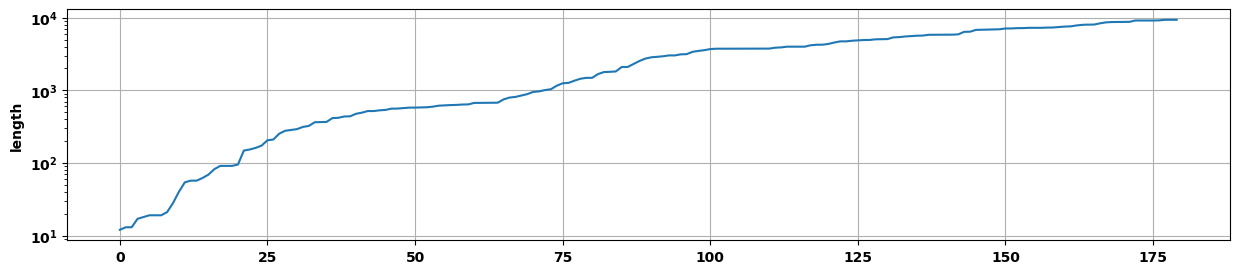

In [36]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,3))
plt.semilogy(df["length"].sort_values().values)
plt.ylabel("length"), plt.grid();

In [37]:
from IPython.display import clear_output
df = df.sort_values("length")
blacklist = list()
for idf, row in df.iterrows():
    unit = row["unit"]
    entity_id = row["entity_id"]
    length = row["length"]
    qstr = f"""SELECT * FROM "{unit}" WHERE entity_id = '{entity_id}'"""
    data = pd.DataFrame.from_records(client.query(qstr).get_points())
    data.time = pd.to_datetime(data.time)
    series = data.set_index("time")["mean_value"]
    title = f"{entity_id=}   {length=}   until={series.index[-1]}"
    try:
        series.plot(figsize=(15, 2), style="o-", ylabel=unit, title=title)
        plt.show()
    except Exception as exception:
        print(f"{exception=}")
    choice = input("('delete'), ('add') to blacklist, ('abort') or (any) to continoue?")
    clear_output()
    if choice == "abort":
        break
    elif choice == "add":
        blacklist.append(row.to_dict())
    elif choice == "delete":
        confirm = input("Are you really sure to delete, then type 'confirm'")
        if confirm == "confirm":
            print(f"Deleting {entity_id=} ...")
            delete_str = f"""DELETE FROM "{unit}" WHERE entity_id = '{entity_id}'"""
            client.query(delete_str)
if blacklist:
    import json
    with open("entity_blacklist.json", "w") as file:
        json.dump(blacklist, file)

In [44]:
with open("entity_blacklist.json", "r") as file:
    data = json.load(file)

df = pd.DataFrame.from_records(data)
df = df.drop(axis=1, labels=["length"])
df = df.sort_values("entity_id").set_index("entity_id")
df.to_csv("entity_blacklist.csv")